In [ ]:
import os
import sys

# Define the relative path to the parent directory
relative_path = '..'

# Append the parent directory to the Python path
parent_directory = os.path.abspath(os.path.join(os.getcwd(), relative_path))
sys.path.append(parent_directory)


from functions.functions import *
import torch
import matplotlib.pyplot as plt
import numpy as np
from functions.functions_time_model import *
from functions.functions_different_inputs import *

#import stuff from library
from functions.fno_wrapper import FNO1dWrapper as FNO1d
from neuralop import Trainer
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

# FNO - 2nd Architecture

## low energy states

In [36]:
# Define parameters
N = 8 # Number of particles
num_states = 5000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size=32
hidden_channels= 512
proj_lift_channel=1024
input_t=15
output_t=10
epochs=200
lr=1e-3
populated_states=50
modes= 8#input_t//2


In [6]:
J_min = -2  # min value for J
J_max = 2   # max value for J
Jx = -0.5850194547979135 #np.random.uniform(J_min, J_max)
Jy = 0.012169377995936426 #np.random.uniform(J_min, J_max)
Jz = -1.1938718983540726 #np.random.uniform(J_min, J_max)
h= -1.6472760245111124 #np.random.uniform(J_min, J_max)
print(Jx,Jy,Jz,h)

hamiltonian= construct_hamiltonian(N,Jx,Jy,Jz,h)
time=0.314

-0.5850194547979135 0.012169377995936426 -1.1938718983540726 -1.6472760245111124


In [7]:
import os

# Set the GPU to be used
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Your code here


In [8]:

steps =100
dataset=create_time_data_set_low_energy_states(N,num_states,populated_states,hamiltonian,time,steps)

In [9]:
train_loader,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)

[Dataset] x_train: torch.Size([4000, 258, 15]), y_train: torch.Size([4000, 256, 15])
[Dataset] x_test: torch.Size([1000, 258, 15]), y_test: torch.Size([1000, 256, 15])


In [ ]:
model = FNO1d(n_modes_height=modes,
        hidden_channels=hidden_channels,
        in_channels=2**N+2,
        out_channels=2**N,
        Complex=True,
        lifting_channels=proj_lift_channel,
        projection_channels=proj_lift_channel,
        arch_no=2,)
model = model.to('cuda')

In [38]:
optimizer = torch.optim.AdamW(model.parameters(),lr=lr) 
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.999) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.9)

#optimizer = torch.optim.SGD(model.parameters(),lr=10e-3,momentum=0.9, weight_decay=1e-4)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [39]:
l2loss = LpLoss(d=1, reduce_dims=[0, 1], p=2,reductions=['sum','mean']) 
h1loss = H1Loss(d=1, reduce_dims=[0, 1],reductions=['sum','mean'])

def mse_loss(y_pred, y, **kwargs):
    assert y_pred.shape == y.shape
    assert y_pred.ndim == 3
    diff = (y_pred - y) 
    loss = (diff * diff.conj()).mean(dim=-1).sum(dim=[0,1])
    return loss.real

train_loss = mse_loss # h1loss
eval_losses={'h1': h1loss, 'l2': l2loss} 

In [40]:
import wandb
    
config = { 
    "No_of_particles": N,
    "batch_size": batch_size,
    "n_train": num_states * train_ratio,
    "n_test": num_states * (1 - train_ratio),
    "learning_rate": lr,
    "hidden_channel": hidden_channels,
    "proj/lift": proj_lift_channel,
    "epochs": epochs,
}


project="fno_arch_2"
name="fno_low_8"
entity= "fs1132429_" # put your username here


wandb_init_args = dict(
        config=config,
        project=project,
        name=name,
        entity=entity,)

In [41]:

device='cuda'


callbacks = [
    BasicLoggerCallback(wandb_init_args)
]
trainer = Trainer(model=model, n_epochs=epochs,
    device=device,
    callbacks=callbacks,
    data_processor=None,
    wandb_log=True,
    log_test_interval=1, # log at every epoch
    use_distributed=False,
    verbose=True)

print(trainer)
trainer.train(train_loader=train_loader,
    test_loaders={"test_loader": test_loader},
    optimizer=optimizer,
    scheduler=scheduler,
    regularizer=False,
    training_loss=train_loss,
    eval_losses=eval_losses,)

avg_loss,█▇▆▅▄▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,███▇▇▆▆▆▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
test_loader_h1,█▇▇▆▆▆▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
test_loader_l2,█▇▇▇▆▇▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
time,▄▆▅▅▅▄▂▅▂▅▄▁▄▄▆▃▄▄▃▄▄▄▄▄▄▃▅▆▇▆▆▆▆▆▅▅▇▆▅█
train_err,█▇▆▅▄▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_loss,0.00029
lr,0.00021
test_loader_h1,0.10961
test_loader_l2,0.0951
time,3.60846


using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False
Training on 4000 samples
Testing on [200] samples         on resolutions ['test_loader'].
Raw outputs of size out.shape=torch.Size([32, 256, 15])
[0] time=3.14, avg_loss=1.9355, train_err=61.9355, test_loader_h1=4.5568, test_loader_l2=7.4838
[1] time=2.63, avg_loss=1.8346, train_err=58.7069, test_loader_h1=4.6143, test_loader_l2=3.8203
[2] time=2.77, avg_loss=0.9708, train_err=31.0660, test_loader_h1=3.4409, test_loader_l2=2.8083
[3] time=2.87, avg_loss=0.6586, train_err=21.0754, test_loader_h1=2.6484, test_loader_l2=2.5428
[4] time=2.80, avg_loss=0.4778, train_err=15.2900, test_loader_h1=2.4510, test_loader_l2=2.3795
[5] time=2.83, avg_loss=0.2682, train_err=8.5825, test_loader_h1=2.1483, test_loader_l2=2.0609
[6] time=2.83, avg_loss=0.1284, train_err=4.1090, test_loader_h1=1.7790, test_loader_l2=1.7002
[7] time=2.74, avg_loss=0.0701, train_

{'test_loader_h1': 0.5947462356090546, 'test_loader_l2': 0.6574977338314056}

In [12]:
#torch.save(model.state_dict(), 'models/model_8_low_energy_second_arch.pth')

In [13]:
model.load_state_dict(torch.load('models/model_8_low_energy_second_arch.pth')) #load the model architecture first
model.eval()  

FNO1d(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexDenseTensor(shape=torch.Size([128, 128, 8]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x ComplexValued(
        (fr): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
        (fi): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
  )
  (lifting): ComplexValued(
    (fr): MLP(
      (fcs): ModuleList(
        (0): Conv1d(258, 256, kernel_size=(1,), stride=(1,))
        (1): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
      )
    )
    (fi): MLP(
      (fcs): ModuleList(
        (0): Conv1d(258, 256, kernel_size=(1,), stride=(1,))
        (1): Conv1d(256, 128, kernel_size=(1,), stride=(1,))
      )
    )
  )
  (projection): ComplexValued(
    (fr): MLP(
      (fcs): ModuleList(
        (0): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
        (1): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      )
   

[Dataset] x_train: torch.Size([800, 258, 15]), y_train: torch.Size([800, 256, 15])
[Dataset] x_test: torch.Size([200, 258, 15]), y_test: torch.Size([200, 256, 15])


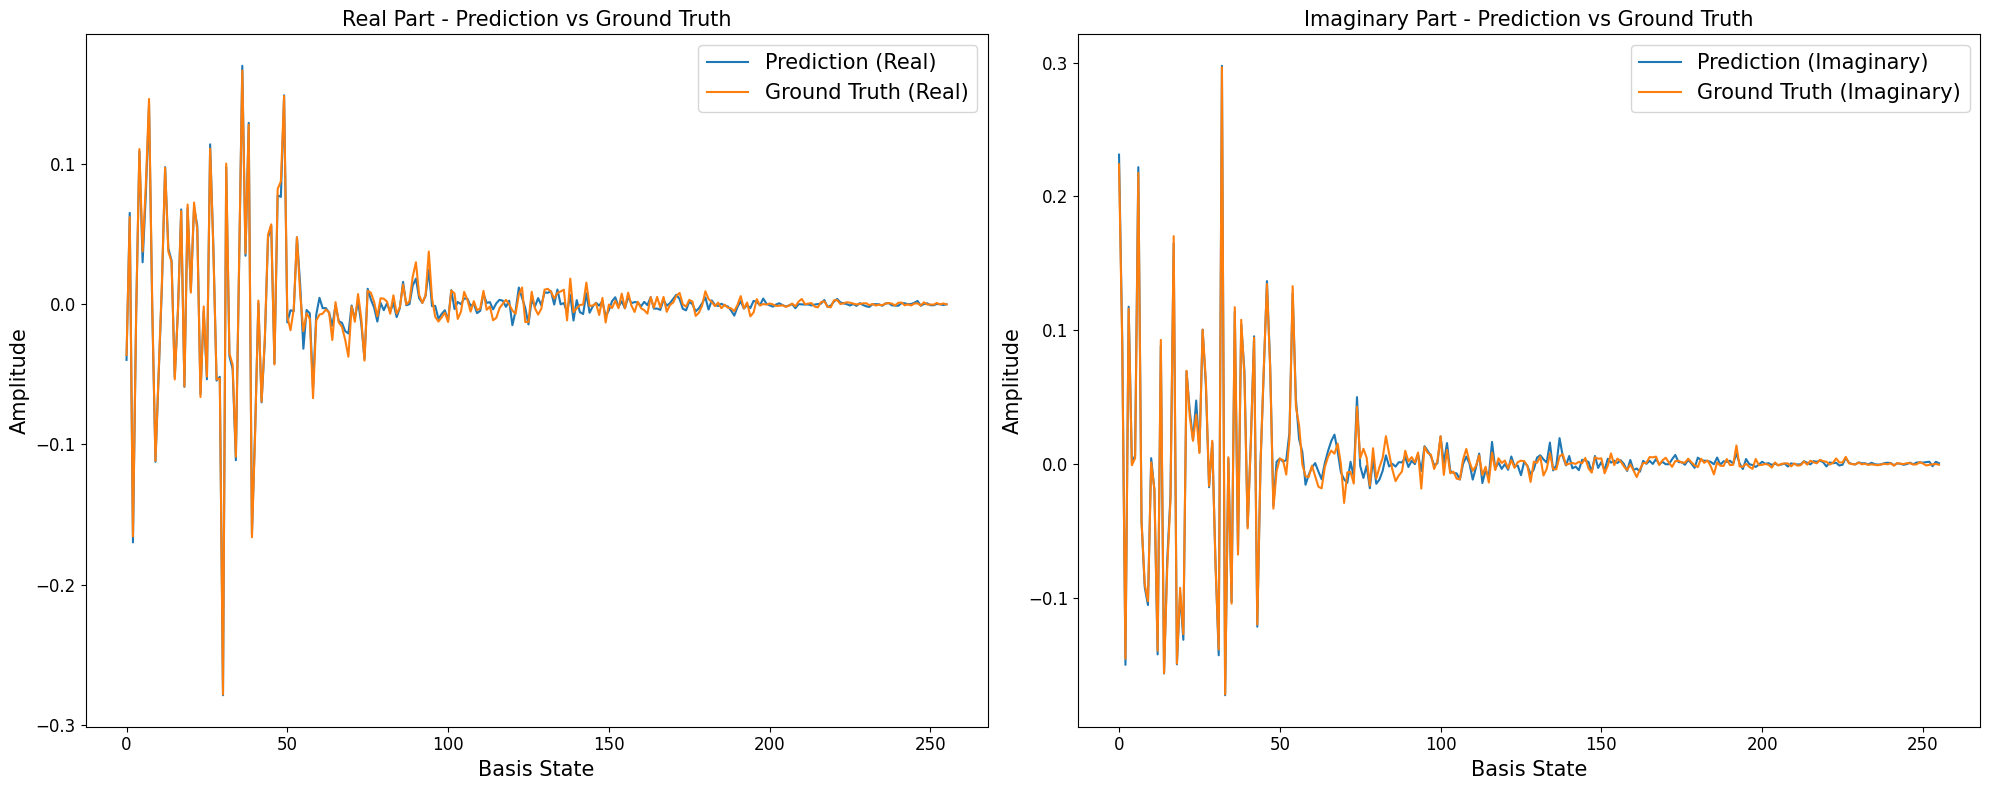

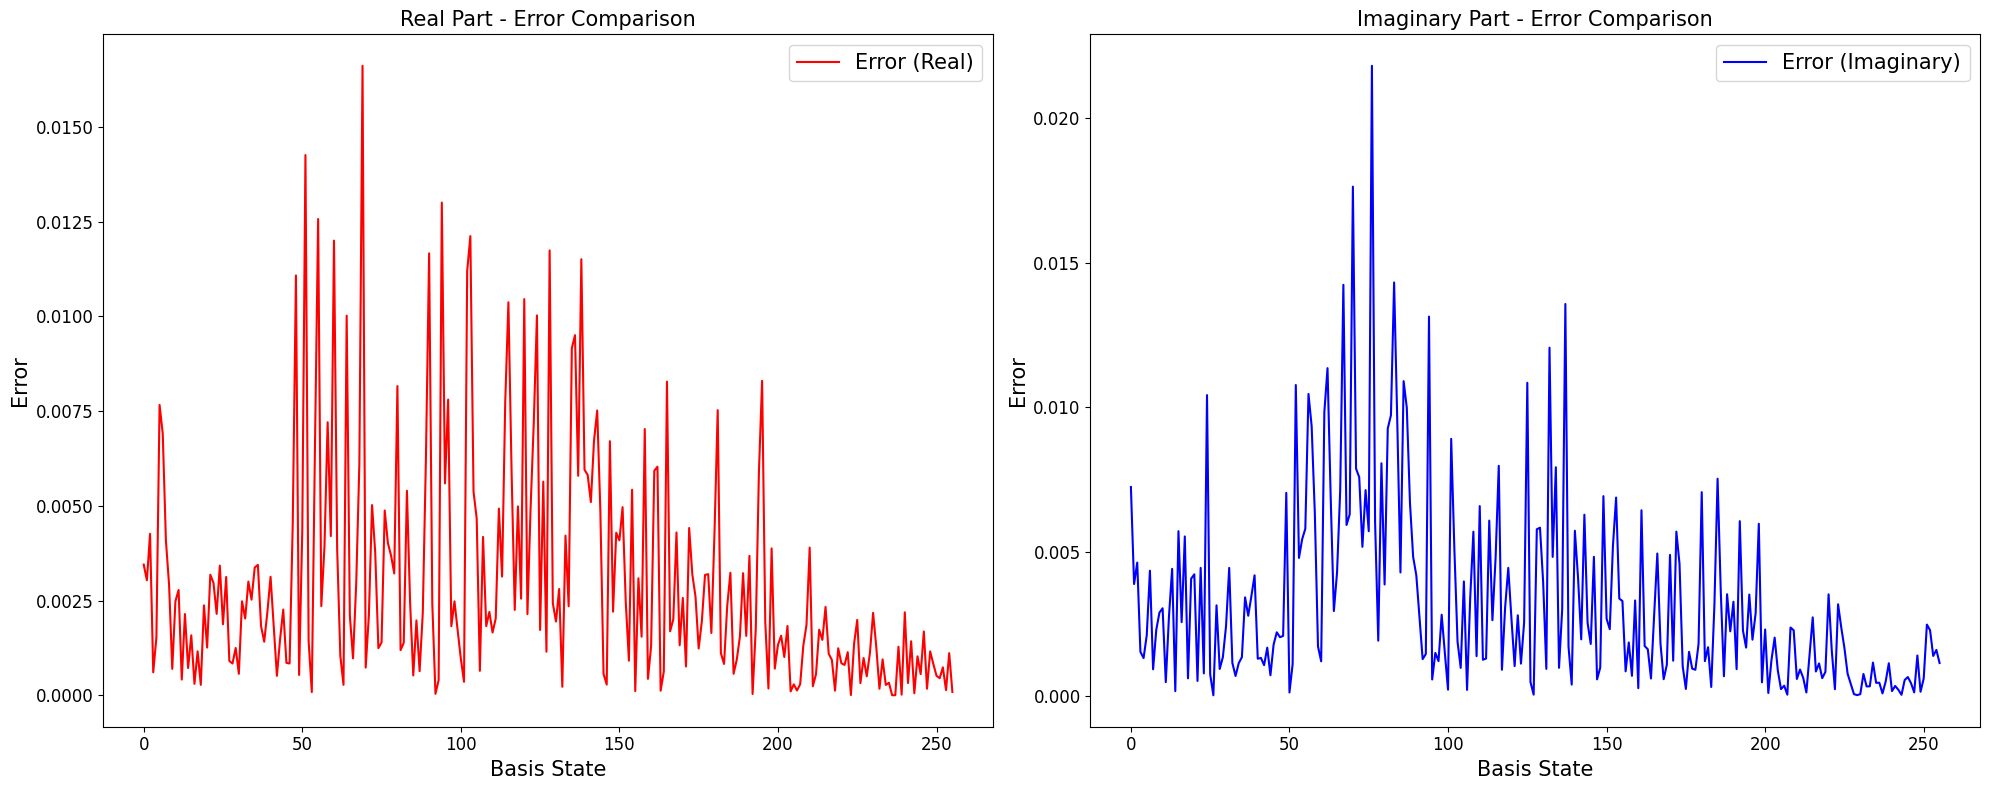

In [42]:

num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5
steps=100
dataset=create_time_data_set_low_energy_states(N,num_states,populated_states,hamiltonian,time,steps)
_,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)
# Assuming `test_loader` is already defined
# Iterate through the test dataset and perform inference
predictions_list = []
ground_truth_list = []
for batch in test_loader:
    x, y = batch['x'].cuda(), batch['y'].cuda()  # Move data to GPU if available
    with torch.no_grad():
        predictions = model(x)  # Perform inference without gradient computation
    predictions_list.append(predictions.cpu())
    ground_truth_list.append(y.cpu())

# Concatenate predictions and ground truth across batches
predictions = torch.cat(predictions_list,dim=0)
ground_truth = torch.cat(ground_truth_list,dim=0)

# Plot the comparison with error
plot_comparison_with_error2(predictions[0,:,1], ground_truth[0,:,1])  # Plot for the first sample in the dataset


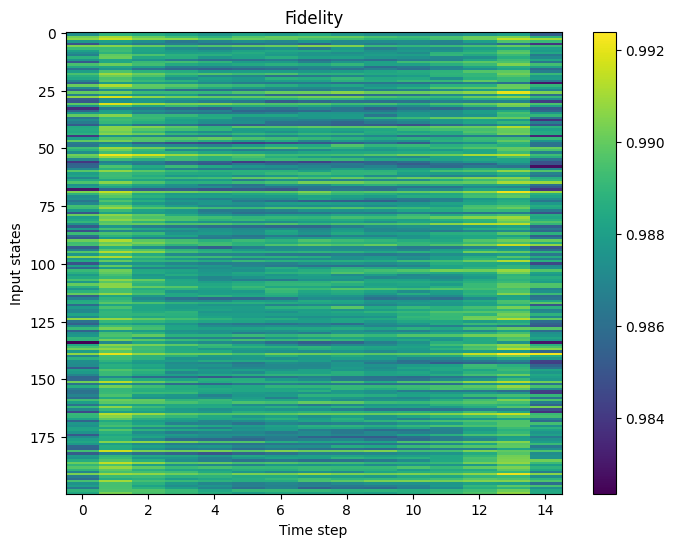

In [43]:
fidelity,avg,mean_total=fidelity_func(predictions,ground_truth)

plt.figure(figsize=(8, 6))
plt.imshow(fidelity, cmap='viridis', interpolation='none', aspect='auto')  # Set aspect='auto' or 'equal'
plt.colorbar()  # Add color bar
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('Input states')
plt.show()

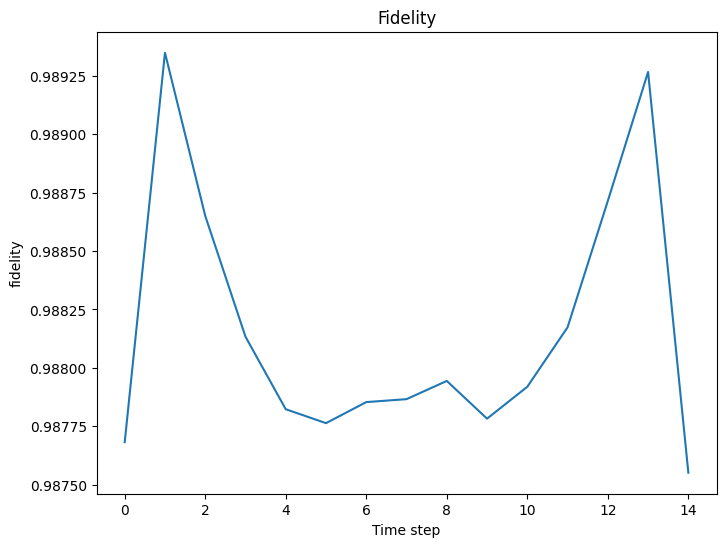

In [44]:
plt.figure(figsize=(8, 6))
plt.plot(avg)
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('fidelity')
plt.show()

In [18]:
print("mean", torch.mean(avg))

mean tensor(0.9997)


## autoregressive rollout

In [26]:
# Example usage
from neuralop.layers.embeddings import PositionalEmbedding


num_states = 1000  # Number of input states
train_ratio = 0.8  # Ratio of training to testing data
batch_size = 5

rollout_steps = 10  # Number of autoregressive rollout steps

steps=200

start_index=0
timesteps = torch.linspace(start_index, start_index+input_t,input_t)
pos_embedding = PositionalEmbedding(2)
positional_embeddings = pos_embedding(timesteps)
pos=positional_embeddings.T.repeat(batch_size, 1, 1)


dataset=create_time_data_set_low_energy_states(N,num_states,populated_states,hamiltonian,time, steps)
_,test_loader=data_preprocess(dataset,input_t,output_t,num_states,train_ratio,batch_size)
train_size = int(train_ratio * num_states)

dataset1=dataset[train_size:,:,:]

predictions, ground_truth = autoregressive_rollout2(model,test_loader, dataset1,rollout_steps,pos.cuda(),output_t,input_t,overlap=True)


[Dataset] x_train: torch.Size([800, 258, 15]), y_train: torch.Size([800, 256, 15])
[Dataset] x_test: torch.Size([200, 258, 15]), y_test: torch.Size([200, 256, 15])
torch.Size([200, 256, 100])
torch.Size([200, 256, 100])


In [27]:
predictions = predictions.cpu()
ground_truth=ground_truth.cpu()
print(predictions.shape)
print(ground_truth.shape)

torch.Size([200, 256, 100])
torch.Size([200, 256, 100])


In [28]:
wavefunction_gt= ground_truth[10,:,:]
wavefunction_pr= predictions[10,:,:]

pop_gt= torch.abs(wavefunction_gt)**2
pop_pr= torch.abs(wavefunction_pr)**2



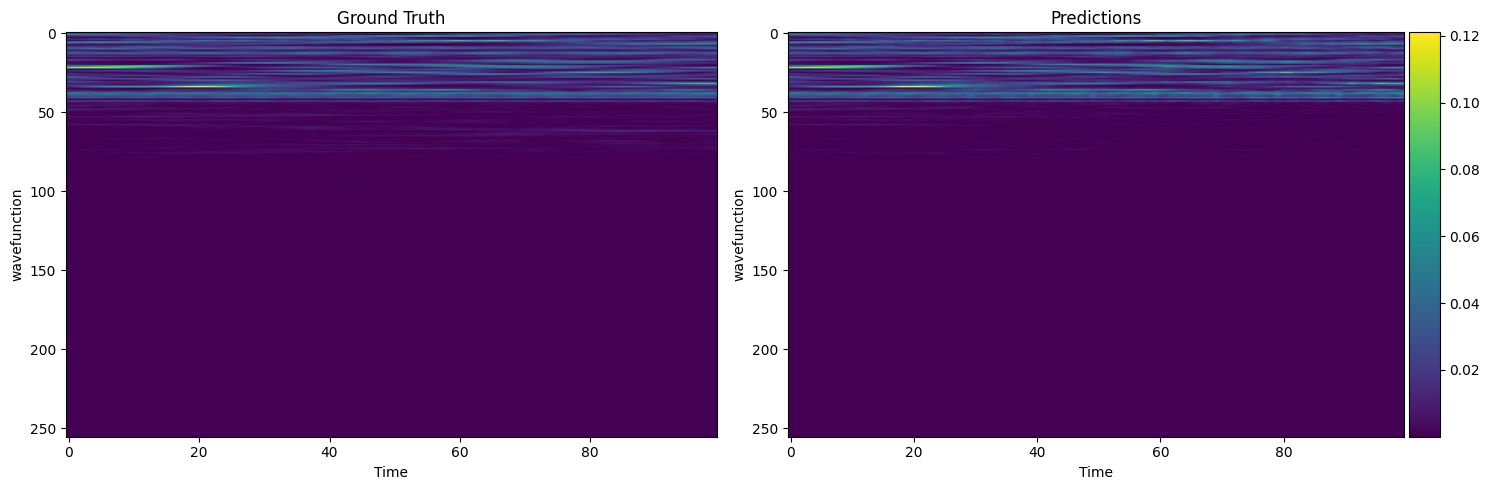

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a figure with 2 subplots in a row
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Define a common normalization for both plots
vmin = min(pop_gt.min(), pop_pr.min())
vmax = max(pop_gt.max(), pop_pr.max())
norm = plt.Normalize(vmin=vmin, vmax=vmax)

# First plot
im1 = axs[0].imshow(pop_gt, cmap='viridis', norm=norm, aspect='auto')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("wavefunction")
axs[0].set_title("Ground Truth")

# Second plot
im2 = axs[1].imshow(pop_pr, cmap='viridis', norm=norm, aspect='auto')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("wavefunction")
axs[1].set_title("Predictions")

# Create an axis on the right side of the figure for the color bar
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

# Add the color bar to the new axis
fig.colorbar(im1, cax=cax)

plt.tight_layout()

# Show the plots
plt.show()


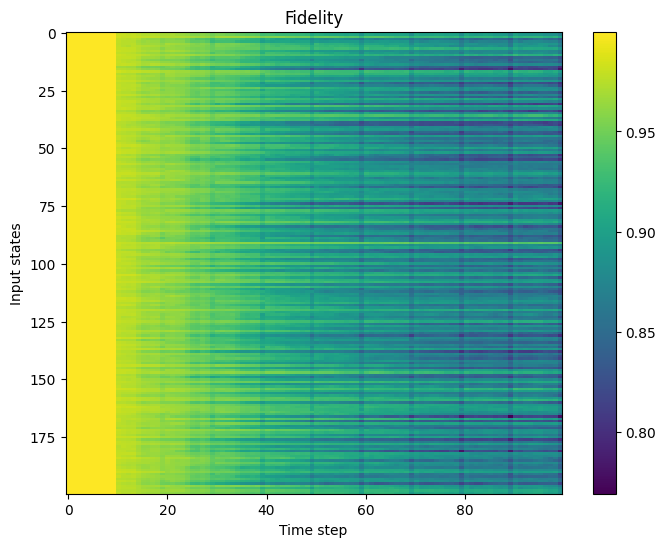

In [30]:
fidelity,avg,fidelity_std=fidelity_func(predictions,ground_truth)

plt.figure(figsize=(8, 6))
plt.imshow(fidelity, cmap='viridis', interpolation='none', aspect='auto')  # Set aspect='auto' or 'equal'
plt.colorbar()  # Add color bar
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('Input states')
plt.show()

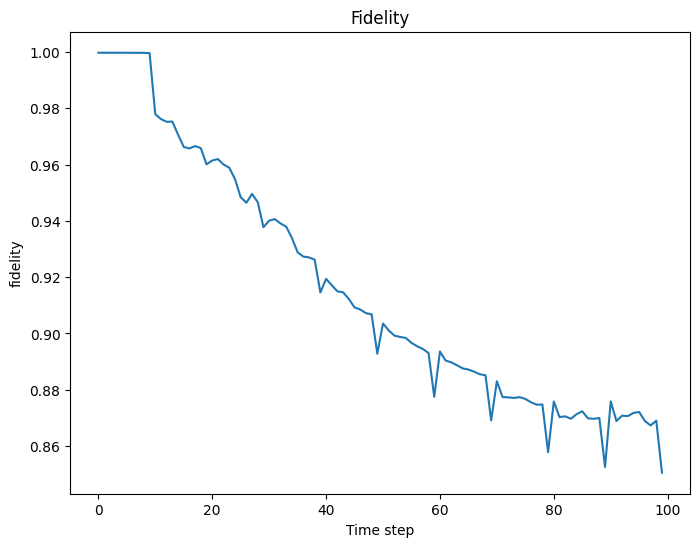

In [31]:

plt.figure(figsize=(8, 6))
plt.plot(avg)
plt.title('Fidelity')
plt.xlabel('Time step')
plt.ylabel('fidelity')
plt.show()

In [32]:
print("mean:", torch.mean(avg[:10]))
print("std:", torch.std(fidelity_std[:10]))
print("mean:", torch.mean(avg[10:]))
print("std:", torch.std(fidelity_std[10:]))

mean: tensor(0.9997)
std: tensor(4.0729e-06)
mean: tensor(0.9066)
std: tensor(0.0079)


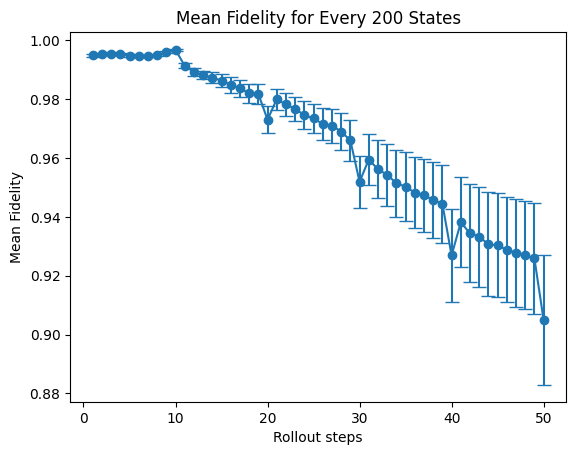

Total Mean Fidelity: tensor(0.9656)
Total Standard Deviation of Fidelity: tensor(0.0067)


In [21]:


# Calculate total mean and standard deviation fidelity
total_mean_fidelity = torch.mean(avg[:50])
total_std_fidelity = torch.std(fidelity_std[:50])

# Plot mean fidelity for every 200 states with error bars (standard deviation)
plt.errorbar(range(1, len(avg[:50]) + 1), avg[:50], yerr=fidelity_std[:50], marker='o', capsize=5)
plt.xlabel('Rollout steps')
plt.ylabel('Mean Fidelity')
#plt.xticks([1, 3, 5, 7, 9])  # Change this for different rollout steps
plt.title(f'Mean Fidelity for Every {200} States')
plt.show()

# Print total mean and standard deviation
print("Total Mean Fidelity:", total_mean_fidelity)
print("Total Standard Deviation of Fidelity:", total_std_fidelity)

In [30]:
# Directory path
models_folder = "figures_data"
subfolder_name = "new_inputs_second_arch_8"
subfolder_path = os.path.join(models_folder, subfolder_name)

# Create the new folder inside models
os.makedirs(subfolder_path, exist_ok=True)

# Save the mean fidelities and standard deviations
np.save(os.path.join(subfolder_path, "mean_fidelities_len.npy"), avg)
np.save(os.path.join(subfolder_path, "std_fidelities_len.npy"), fidelity_std)
